<a href="https://colab.research.google.com/github/Ibraheem101/mlops/blob/main/foundations/Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word embeddings

The motivation for word embeddings in natural language processing (NLP) arises from the need to represent words in a numerical format that captures their semantic and syntactic similarities. Traditional approaches in NLP, such as one-hot encoding or bag-of-words representations, treat words as discrete symbols with no inherent meaning or relationship between them. However, words do possess rich contextual information and often exhibit semantic connections based on their usage in text.

Word embeddings aim to address this limitation by representing words as dense vectors in a continuous vector space. The key motivation behind word embeddings is to capture the meaning and relationships between words based on their distributional properties in a given corpus. The underlying idea is that words that occur in similar contexts tend to have similar meanings.

By learning word embeddings, NLP models can benefit from several advantages:

* Semantic Similarity: Word embeddings capture semantic relationships between words. Words with similar meanings or concepts are represented by vectors that are closer to each other in the embedding space. For example, the vectors for "king" and "queen" would be closer to each other than to the vector for "apple."

* Syntactic Regularities: Word embeddings can capture syntactic regularities and analogies between words. For example, the vector difference between "man" and "woman" might be similar to the vector difference between "king" and "queen," capturing the analogy between gendered terms.

* Dimensionality Reduction: Word embeddings provide a lower-dimensional representation of words compared to one-hot encoding or bag-of-words models. This reduces the dimensionality of the input space and helps mitigate the curse of dimensionality in NLP tasks.

* Generalization: Word embeddings can generalize to unseen words or rare words by leveraging the similarities learned from the training data. Models can infer similarities and relationships for words not explicitly encountered during training, which is valuable for handling out-of-vocabulary words.

* Efficiency: Word embeddings reduce the computational complexity of NLP models by representing words as continuous vectors. This enables efficient processing and computation compared to sparse representations.

In [1]:
import os
import re
import json
import math
import nltk
import torch
import gensim
import random
import urllib
import itertools
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

We can learn embeddings by creating our models in PyTorch but first, we're going to use a library that specializes in embeddings and topic modeling called Gensim.

In [2]:
nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
seed = 1234

In [4]:
def set_seeds(seed=1234):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # multi-GPU

In [5]:
set_seeds(seed = seed)

### Load data

In [6]:
# Split text into sentences
tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")
book = urllib.request.urlopen(url="https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/harrypotter.txt")
sentences = tokenizer.tokenize(str(book.read()))
print (f"{len(sentences)} sentences")

12449 sentences


In [7]:
sentences[26]

'He seemed unable to prevent himself from glancing upward every minute or so.\\r\\n"Yaxley.'

In [8]:
def preprocess(text):

    # lowercasing
    text = text.lower()

    # Spacing and filters
    text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
    text = re.sub("[^A-Za-z0-9]+", " ", text) # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()

    # Separate into word tokens
    text = text.split(" ")

    return text

In [9]:
print(sentences[27])
sentences = [preprocess(sentence) for sentence in sentences]
print(sentences[27])

Snape," said a high, clear voice from the head of the table.
['snape', 'said', 'a', 'high', 'clear', 'voice', 'from', 'the', 'head', 'of', 'the', 'table']


<details>
    <summary>Approaches to learning embeddings</summary>

1. Continuous Bag of Words (CBOW):
In CBOW, the objective is to predict the target word based on the context words surrounding it.
The model takes a fixed-size context window of words as input and tries to predict the target word in the middle.
The context words are typically represented as one-hot vectors or pre-trained word embeddings.
The model is trained using a neural network, where the context words are passed through an embedding layer, followed by a hidden layer, and finally a softmax output layer.
The embedding layer learns the dense representations (embeddings) of the context words, which are updated during training to improve the prediction accuracy.
The learned embeddings capture the semantic and syntactic relationships between words based on their co-occurrence patterns.

2. Skip-gram:
In skip-gram, the objective is to predict the context words given a target word.
The model takes a target word as input and tries to predict the surrounding context words.
Similar to CBOW, the context words can be represented as one-hot vectors or pre-trained embeddings.
The model architecture consists of an embedding layer followed by a hidden layer and a softmax output layer.
During training, the model adjusts the embeddings to maximize the probability of predicting the correct context words.
The skip-gram approach is useful when we want to focus on rare words and capture more fine-grained relationships between words.

3. Language Modeling (LM):
Language modeling involves predicting the next word in a sequence of words given the previous words.
The objective of LM is to learn the probability distribution of words in a language.
The model takes a sequence of words as input and tries to predict the next word.
It typically uses recurrent neural network (RNN) architectures, such as LSTM or GRU, to capture the sequential dependencies between words.
The embeddings are learned as part of the training process, where the model updates the embeddings based on the predicted probabilities.
Language models can be trained on large text corpora and can capture the contextual relationships between words.
These approaches learn word embeddings by training neural network models on large amounts of text data. By considering the context of words, they capture the semantic and syntactic relationships, allowing words with similar meanings or usage to have similar embeddings. The resulting embeddings can then be used in various NLP tasks such as sentiment analysis, machine translation, and text generation.
</details>

### Word2vec
[Understand Word2vec](https://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)

In [10]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

In [11]:
embedding_dim = 100
window = 5
min_count = 3 # Ignores all words with total frequency lower than this
skip_gram = 1 # 0 = CBOW
negative_sampling = 20

In [12]:
# Super fast because of optimized C code under the hood
w2v = Word2Vec(
    sentences=sentences, vector_size=embedding_dim,
    window=window, min_count=min_count,
    sg=skip_gram, negative=negative_sampling)
print(w2v)

Word2Vec<vocab=4937, vector_size=100, alpha=0.025>


In [13]:
# Vector for each word
w2v.wv.get_vector("harry"), len(w2v.wv.get_vector("harry")) #embedding vector e

(array([ 0.05554148,  0.51449263,  0.02647996, -0.00736882,  0.2349285 ,
        -0.40939453,  0.2834695 ,  0.31534404, -0.76638186, -0.15783367,
        -0.07916379, -0.1458145 , -0.04332679, -0.03518606, -0.14897653,
         0.03334299,  0.4691548 , -0.15601353, -0.31418338, -0.34821525,
        -0.25019428,  0.28169018,  0.26391193, -0.5085285 ,  0.02704121,
        -0.04683833, -0.7389701 ,  0.08067881, -0.18744688, -0.14420679,
         0.2577306 ,  0.17539772, -0.0375921 , -0.08126716, -0.13365084,
        -0.01302763,  0.00153566, -0.04877523,  0.1027067 , -0.07905056,
        -0.24179678, -0.05977676,  0.003861  ,  0.3214272 ,  0.19556916,
        -0.23822756,  0.02331826, -0.12167119, -0.18695211, -0.04624409,
         0.14287955,  0.12043853, -0.07325423,  0.19841047, -0.30535713,
        -0.48660335,  0.24522428, -0.26716396, -0.27490684,  0.06907767,
         0.16472767, -0.06080765,  0.3233195 ,  0.10316559, -0.23501824,
         0.12153216,  0.04402173, -0.09647799, -0.0

In [14]:
# Get nearest neighbors (excluding itself)
w2v.wv.most_similar(positive="man", topn=5)

[('woman', 0.9084859490394592),
 ('witch', 0.901517391204834),
 ('wizard', 0.8934826850891113),
 ('odd', 0.8744949102401733),
 ('familiar', 0.8743767142295837)]

In [15]:
# Saving and loading
w2v.wv.save_word2vec_format("model.bin", binary=True)
w2v = KeyedVectors.load_word2vec_format("model.bin", binary=True)

### FastText
When a word doesn't exist in our vocabulary, there are a few approaches we can take to handle it:

UNK Token:

One common approach is to assign a special token, often called the "UNK" token, to represent out-of-vocabulary words.
During training, if a word is encountered that is not present in the vocabulary, it is replaced with the UNK token.
The UNK token allows the model to learn a representation for unknown words and treat them similarly during inference.
FastText:

FastText, as you mentioned, uses character-level n-grams to embed words. This technique enables it to handle rare words, misspelled words, and even words that are not present in the training corpus.
By breaking down words into smaller subword units (character n-grams), FastText can still capture some information about the meaning of the word, even if it is unseen.
When encountering an out-of-vocabulary word, FastText can leverage the character n-gram information to generate an embedding for the word based on the embeddings of its subword units.
This approach can be particularly useful in scenarios where the vocabulary is limited or when dealing with morphologically rich languages.

In [16]:
from gensim.models import FastText

In [17]:
# Super fast because of optimized C code under the hood
ft = FastText(sentences=sentences, vector_size=embedding_dim,
              window=window, min_count=min_count,
              sg=skip_gram, negative=negative_sampling)
print(ft)

FastText<vocab=4937, vector_size=100, alpha=0.025>


In [18]:
# This word doesn't exist so the word2vec model will error out
try:
    w2v.most_similar(positive="scarring", topn=5)
except KeyError:
    print("The word doesn't exist in the vocabulary")

The word doesn't exist in the vocabulary


In [19]:
# FastText will use n-grams to embed an OOV word
ft.wv.most_similar(positive="scarring", topn=5)

[('swimming', 0.9929739236831665),
 ('dabbing', 0.9921905398368835),
 ('howling', 0.9920710921287537),
 ('quivering', 0.9915287494659424),
 ('muffling', 0.9915011525154114)]

In [20]:
# Save and loading
ft.wv.save("model.bin")
ft = KeyedVectors.load("model.bin")

In [21]:
ft.most_similar(positive="scarring", topn=5)

[('swimming', 0.9929739236831665),
 ('dabbing', 0.9921905398368835),
 ('howling', 0.9920710921287537),
 ('quivering', 0.9915287494659424),
 ('muffling', 0.9915011525154114)]

### GloVe
GloVe (Global Vectors for Word Representation) is an unsupervised learning algorithm for generating word embeddings. It constructs a co-occurrence matrix from a large corpus of text, initializes word vectors, defines an objective function based on co-occurrence statistics, and optimizes the word vectors to capture semantic relationships. The resulting word embeddings are dense vector representations that capture similarities between words. GloVe leverages global statistical information and performs well in various NLP tasks.

In [22]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
from sklearn.decomposition import PCA
from gensim.scripts.glove2word2vec import glove2word2vec

In [23]:
def plot_embeddings(words, embeddings, pca_results):
    for word in words:
        index = embeddings.index_to_key.index(word)
        plt.scatter(pca_results[index, 0], pca_results[index, 1])
        plt.annotate(word, xy=(pca_results[index, 0], pca_results[index, 1]))
    plt.show()

<details>
    <summary>Explanation</summary>
    
The function plot_embeddings takes three arguments: words, embeddings, and pca_results. Here's a breakdown of what the function does:
It iterates over each word in the words list.
For each word, it retrieves the corresponding index in the embeddings object using embeddings.index2word.index(word).
It plots a scatter point on a 2D plot using the x and y coordinates from pca_results.
It annotates the scatter point with the word using plt.annotate.
Finally, it displays the plot using plt.show().
The purpose of this function is to visualize word embeddings in a 2D space using PCA (Principal Component Analysis) results. It plots the words as scatter points and annotates each point with its corresponding word. The embeddings object represents a collection of word embeddings, and pca_results contains the PCA-transformed coordinates for each embedding. The words list specifies which words to visualize.
</details>

### Load

In [24]:
cd content

[Errno 2] No such file or directory: 'content'
/content


In [25]:
cp kaggle.json ~/.kaggle/

In [26]:
! chmod 600 /root/.kaggle/kaggle.json

In [27]:
! kaggle datasets download -d anindya2906/glove6b

 99% 835M/844M [00:10<00:00, 78.6MB/s]
100% 844M/844M [00:10<00:00, 83.7MB/s]


In [28]:
# Unzip the file (may take ~3-5 minutes)
# Specify the path to the zip file
zip_path = "../content/glove6b.zip"

# Open the zip file
with ZipFile(zip_path, 'r') as zip_ref:
    # Extract all the contents of the zip file
    zip_ref.extractall("../content/")

In [29]:
# Write embeddings to file
embeddings_file = "glove.6B.{0}d.txt".format(embedding_dim)

In [30]:
# Preview of the GloVe embeddings file
with open(embeddings_file, "r") as fp:
    line = next(fp)
    values = line.split()
    word = values[0]
    embedding = np.asarray(values[1:], dtype='float32')
    print (f"word: {word}")
    print (f"embedding:\n{embedding}")
    print (f"embedding dim: {len(embedding)}")

word: the
embedding:
[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459


In [31]:
# Save GloVe embeddings to local directory in word2vec format
word2vec_output_file = "{0}.word2vec".format(embeddings_file)
glove2word2vec(embeddings_file, word2vec_output_file)

<ipython-input-31-b004bd08d681>:3: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(embeddings_file, word2vec_output_file)


(400000, 100)

In [32]:
# Load embeddings (may take a minute)
glove = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [33]:
# (king - man) + woman = ?
# king - man = ? -  woman
glove.most_similar(positive=["woman", "king"], negative=["man"], topn=5)

[('queen', 0.7698540687561035),
 ('monarch', 0.6843381524085999),
 ('throne', 0.6755736470222473),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520534157752991)]

In [34]:
glove.most_similar(positive=["woman", "boy"], negative=["man"], topn=5)

[('girl', 0.9095936417579651),
 ('mother', 0.7666921019554138),
 ('child', 0.7420270442962646),
 ('pregnant', 0.7282999157905579),
 ('girls', 0.7268646359443665)]

In [35]:
# Get nearest neighbors (excluding itself)
glove.most_similar(positive="hey", topn=5)

[('yeah', 0.8196864128112793),
 ('gonna', 0.7466485500335693),
 ('ok', 0.74472576379776),
 ('hello', 0.7171452045440674),
 ('`', 0.7170859575271606)]

In [36]:
# Reduce dimensionality for plotting
X = np.array([glove.get_vector(word) for word in glove.index_to_key])
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X)

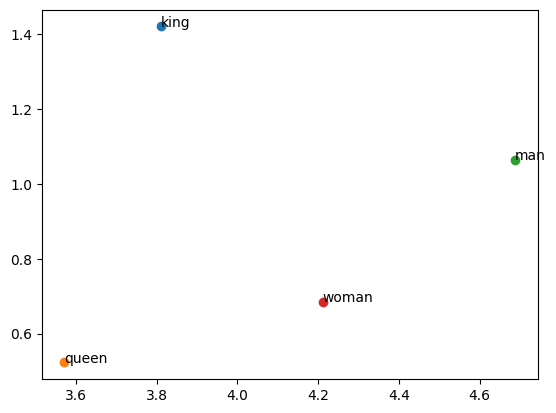

In [37]:
# Visualize
plot_embeddings(
    words=["king", "queen", "man", "woman"], embeddings=glove,
    pca_results=pca_results)


In [38]:
# Bias in embeddings
glove.most_similar(positive=["woman", "doctor"], negative=["man"], topn=5)

[('nurse', 0.7735227942466736),
 ('physician', 0.7189430594444275),
 ('doctors', 0.6824328303337097),
 ('patient', 0.6750683188438416),
 ('dentist', 0.6726033091545105)]

In [39]:
# Set device
cuda = True
device = torch.device("cuda" if (
    torch.cuda.is_available() and cuda) else "cpu")
torch.set_default_tensor_type("torch.FloatTensor")
if device.type == "cuda":
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
print (device)

cpu


In [40]:
# Load data
url = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/news.csv"
df = pd.read_csv(url, header=0) # load
df = df.sample(frac=1).reset_index(drop=True) # shuffle
df.head()

,title,category
0,O #39;Hare to reduce flight arrivals,Business
1,Canceled Contract Clouds China #39;s IT Procur...,Sci/Tech
2,Dow Jones Buying MarketWatch for \$519 Million,Sci/Tech
3,A sky-high Swedish farewell cake poisons 13 (AFP),World
4,Dodgers Continue Winter Trade Talks (AP),Sports


In [41]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer

In [42]:
nltk.download("stopwords")
stop_words = stopwords.words("english")
print (stop_words[:5])
snowball = SnowballStemmer('english')

['i', 'me', 'my', 'myself', 'we']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
def preprocess(text, stopwords = stop_words):

    # lowercasing
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r"\b(" + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub("", text)

    # Remove words in parenthesis
    text = re.sub(r"\([^)]*\)", "", text)

    # Spacing and filters
    text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)  # separate punctuation tied to words
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()

    return text

In [44]:
# Sample
text = "Great week for the NYSE!"
preprocess(text=text)

'great week nyse'

In [45]:
# Apply to dataframe
preprocessed_df = df.copy()
preprocessed_df.title = preprocessed_df.title.apply(preprocess)
print (f"{df.title.values[0]}\n\n{preprocessed_df.title.values[0]}")

O #39;Hare to reduce flight arrivals

39 hare reduce flight arrivals


### Split data

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
train_size = 0.7
val_size = 0.15
test_size = 0.15

In [48]:
def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=train_size, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test


In [49]:
# Data
X = preprocessed_df["title"].values
y = preprocessed_df["category"].values

In [50]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=train_size)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")

X_train: (84000,), y_train: (84000,)
X_val: (18000,), y_val: (18000,)
X_test: (18000,), y_test: (18000,)
Sample point: knicks dig hole early 39 quite climb → Sports


### Label Encoding

In [51]:
from collections import OrderedDict

In [111]:
class LabelEncoder(object):
    """
        Class to transform categorical labels into numerical values.

        Attributes:
            mapping (dict): A dictionary that maps labels to their corresponding numerical values.
            reverse_mapping (dict): A dictionary that maps numerical values back to their original labels.
            classes (list): A list of unique labels.

        Methods:
            fit(data): Fit the encoder to the given data by creating the mapping and reverse_mapping dictionaries.
            encode(data): Encode the given data by replacing labels with their corresponding numerical values.
            decode(data): Decode the given data by replacing numerical values with their original labels.
            __len__(): Return the number of unique labels in the encoder.
            __str__(): Return a string representation of the encoder.
            save(fp): Save the encoder's mapping dictionary to a JSON file.
            load(fp): Load a saved encoder from a JSON file.

    """


    def __init__(self):
        self.mapping = {}
        self.reverse_mapping = {}
        self.classes = []

    def fit(self, data):
        unique_labels = list(OrderedDict.fromkeys(data))
        for value, label in enumerate(unique_labels):
            self.mapping[label] = value
            self.reverse_mapping[value] = label
            self.classes.append(label)

    def encode(self, data):
        return [self.mapping[i] for i in data]

    def decode(self, data):
        return [self.reverse_mapping[j] for j in data]

    def __len__(self):
        return len(self.mapping)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {'mapping': self.mapping}
            json.dump(contents, fp, indent=4, sort_keys=False)

    # classmethod
    # def load(cls, fp):
    #     with open(fp, "r") as fp:
    #         kwargs = json.load(fp=fp)
    #     return cls(**kwargs)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            contents = json.load(fp=fp)
        encoder = cls()
        encoder.mapping = contents['mapping']
        encoder.reverse_mapping = {v: k for k, v in encoder.mapping.items()}
        encoder.classes = list(encoder.mapping.keys())
        return encoder

In [112]:
# Encode
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
num_classes = len(label_encoder)
label_encoder.mapping

{'Sports': 0, 'World': 1, 'Business': 2, 'Sci/Tech': 3}

In [113]:
# Convert labels to tokens
print (f"y_train[0]: {y_train[0]}")
y_train_enc = label_encoder.encode(y_train)
y_val_enc = label_encoder.encode(y_val)
y_test_enc = label_encoder.encode(y_test)
print (f"y_train[0]: {y_train_enc[0]}")

y_train[0]: Sports
y_train[0]: 0


### Class Weights

In [114]:
# Calculate class weights
class_weights = {}
total_samples = len(y_train_enc)
num_classes = len(np.unique(y_train_enc))
class_samples = np.bincount(y_train_enc)
for i in range(num_classes):
    class_weights[i] = total_samples / (num_classes * class_samples[i])

print(f"Class weights: {class_weights}")

Class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


### Tokenizer

In [115]:
from collections import Counter
from more_itertools import take

In [116]:
class Tokenizer(object):
    def __init__(self, char_level, num_tokens=None,
                 pad_token="<PAD>", oov_token="<UNK>",
                 token_to_index=None):
        self.char_level = char_level
        self.separator = "" if self.char_level else " "
        if num_tokens: num_tokens -= 2 # pad + unk tokens
        self.num_tokens = num_tokens
        self.pad_token = pad_token
        self.oov_token = oov_token
        if not token_to_index:
            token_to_index = {pad_token: 0, oov_token: 1}
        self.token_to_index = token_to_index
        self.index_to_token = {v: k for k, v in self.token_to_index.items()}

    def __len__(self):
        return len(self.token_to_index)

    def __str__(self):
        return f"<Tokenizer(num_tokens={len(self)})>"

    def fit_on_texts(self, texts):
        if not self.char_level:
            texts = [text.split(" ") for text in texts]
        all_tokens = [token for text in texts for token in text]
        counts = Counter(all_tokens).most_common(self.num_tokens)
        self.min_token_freq = counts[-1][1]
        for token, count in counts:
            index = len(self)
            self.token_to_index[token] = index
            self.index_to_token[index] = token
        return self

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            if not self.char_level:
                text = text.split(" ")
            sequence = []
            for token in text:
                sequence.append(self.token_to_index.get(
                    token, self.token_to_index[self.oov_token]))
            sequences.append(np.asarray(sequence))
        return sequences

    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = []
            for index in sequence:
                text.append(self.index_to_token.get(index, self.oov_token))
            texts.append(self.separator.join([token for token in text]))
        return texts

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {
                "char_level": self.char_level,
                "oov_token": self.oov_token,
                "token_to_index": self.token_to_index
            }
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)


In [117]:
# Tokenize
tokenizer = Tokenizer(char_level=False, num_tokens=500)
tokenizer.fit_on_texts(texts=X_train)
VOCAB_SIZE = len(tokenizer)
print (tokenizer)

<Tokenizer(num_tokens=500)>


In [118]:
# Sample of tokens
print (take(5, tokenizer.token_to_index.items()))
print (f"least freq token's freq: {tokenizer.min_token_freq}") # use this to adjust num_tokens

[('<PAD>', 0), ('<UNK>', 1), ('39', 2), ('b', 3), ('gt', 4)]
least freq token's freq: 167


In [119]:
# Convert texts to sequences of indices
X_train_tok = tokenizer.texts_to_sequences(X_train)
X_val_tok = tokenizer.texts_to_sequences(X_val)
X_test_tok = tokenizer.texts_to_sequences(X_test)
preprocessed_text = tokenizer.sequences_to_texts([X_train_tok[0]])[0]
print ("Text to indices:\n"
    f"  (preprocessed) → {preprocessed_text}\n"
    f"  (tokenized) → {X_train_tok[0]}")

Text to indices:
  (preprocessed) → <UNK> <UNK> <UNK> early 39 <UNK> <UNK>
  (tokenized) → [  1   1   1 304   2   1   1]


### Embedding Layer

In [120]:
# Input
vocab_size = 10
x = torch.randint(high=vocab_size, size=(1,5))
print (x)
print (x.shape)

tensor([[5, 8, 8, 5, 1]])
torch.Size([1, 5])


In [121]:
# Embedding layer
embeddings = nn.Embedding(embedding_dim=100, num_embeddings=vocab_size)
print (embeddings.weight.shape)

torch.Size([10, 100])


`print(embeddings.weight.shape)` outputs the shape of the weight matrix, which in this case will be (vocab_size, embedding_dim).

In [122]:
# Embed the input
embeddings(x).shape

torch.Size([1, 5, 100])

Each token in the input is represented via embeddings (all out-of-vocabulary (OOV) tokens are given the embedding for UNK token.) In the model below, we'll see how to set these embeddings to be pretrained GloVe embeddings and how to choose whether to freeze (fixed embedding weights) those embeddings or not during training.

### Padding
In the context of Natural Language Processing (NLP), padding refers to the process of adding special tokens or characters to sequences in order to make them of equal length. It is necessary because many machine learning models require input data of consistent dimensions.

Padding is particularly relevant when working with sequential data, such as sentences or documents, where the length of the text varies. To ensure that all sequences have the same length, shorter sequences are padded with special tokens (such as <PAD>) to match the length of the longest sequence in the dataset.

While embedding our input tokens will create a batch of shape (N, max_seq_len, embed_dim) we only need to provide a 2D matrix (N, max_seq_len) for using embeddings with PyTorch.

In [123]:
def pad_sequences(sequences, max_seq_len=0):
    """Pad sequences to max length in sequence."""
    max_seq_len = max(max_seq_len, max(len(sequence) for sequence in sequences))
    padded_sequences = np.zeros((len(sequences), max_seq_len))
    for i, sequence in enumerate(sequences):
        padded_sequences[i][:len(sequence)] = sequence
    return padded_sequences

In [124]:
# 2D sequences
padded = pad_sequences(X_train_tok[0:3])
print (padded.shape)
print (padded)

(3, 7)
[[  1.   1.   1. 304.   2.   1.   1.]
 [  1.   7. 219.  44. 172.   1.   0.]
 [  1.   1.   1.   1.   0.   0.   0.]]


In [125]:
np.zeros((1, 5))

array([[0., 0., 0., 0., 0.]])

### Dataset

In [126]:
filter_sizes = list(range(1, 4)) # uni, bi and tri grams

In [127]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, max_filter_size):
        self.X = X
        self.y = y
        self.max_filter_size = max_filter_size

    def __len__(self):
        return len(self.y)

    def __str__(self):
        return f"<Dataset(N={len(self)})>"

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return [X, y]

    def collate_fn(self, batch):
        """Processing on a batch."""
        # Get inputs
        batch = np.array(batch)
        X = batch[:, 0]
        y = batch[:, 1]

        # Pad sequences
        X = pad_sequences(X)

        # Cast
        X = torch.LongTensor(X.astype(np.int32))
        y = torch.LongTensor(y.astype(np.int32))

        return X, y

    def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
        return torch.utils.data.DataLoader(
            dataset=self, batch_size=batch_size, collate_fn=self.collate_fn,
            shuffle=shuffle, drop_last=drop_last, pin_memory=True)


In [128]:
# Create datasets
max_filter_size = max(filter_sizes)
train_dataset = Dataset(X=X_train_tok, y=y_train_enc, max_filter_size=max_filter_size)
val_dataset = Dataset(X=X_val_tok, y=y_val_enc, max_filter_size=max_filter_size)
test_dataset = Dataset(X=X_test_tok, y=y_test_enc, max_filter_size=max_filter_size)
print ("Datasets:\n"
    f"  Train dataset:{train_dataset.__str__()}\n"
    f"  Val dataset: {val_dataset.__str__()}\n"
    f"  Test dataset: {test_dataset.__str__()}\n"
    "Sample point:\n"
    f"  X: {train_dataset[0][0]}\n"
    f"  y: {train_dataset[0][1]}")

Datasets:
  Train dataset:<Dataset(N=84000)>
  Val dataset: <Dataset(N=18000)>
  Test dataset: <Dataset(N=18000)>
Sample point:
  X: [  1   1   1 304   2   1   1]
  y: 0


In [129]:
# Create dataloaders
batch_size = 64
train_dataloader = train_dataset.create_dataloader(batch_size=batch_size)
val_dataloader = val_dataset.create_dataloader(batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(batch_size=batch_size)
batch_X, batch_y = next(iter(train_dataloader))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  y: {list(batch_y.size())}\n"
    "Sample point:\n"
    f"  X: {batch_X[0]}\n"
    f"  y: {batch_y[0]}")

Sample batch:
  X: [64, 14]
  y: [64]
Sample point:
  X: tensor([  1,   1,   1, 304,   2,   1,   1,   0,   0,   0,   0,   0,   0,   0])
  y: 0


<ipython-input-127-b117a8ba9edc>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch = np.array(batch)


### Model

Let's visualize the model's forward pass.

1. We'll first tokenize our inputs (batch_size, max_seq_len).
2. Then we'll embed our tokenized inputs (batch_size, max_seq_len, embedding_dim).
3. We'll apply convolution via filters (filter_size, embedding_dim, num_filters) followed by batch normalization. Our filters act as character level n-gram detectors. We have three different filter sizes (2, 3 and 4) and they will act as bi-gram, tri-gram and 4-gram feature extractors, respectively.
4. We'll apply 1D global max pooling which will extract the most relevant information from the feature maps for making the decision.
5. We feed the pool outputs to a fully-connected (FC) layer (with dropout).
6. We use one more FC layer with softmax to derive class probabilities.

The visualization describes the forward pass of a model that processes inputs using convolutional neural networks (CNN) for text classification. Here's a step-by-step explanation:

1. Tokenization: The input text is tokenized, which means breaking it into individual tokens or words. The shape of the input tensor is (batch_size, max_seq_len), where batch_size represents the number of samples in a batch, and max_seq_len represents the maximum length of the input sequences.

2. Embedding: The tokenized inputs are then embedded using an embedding layer. This layer maps each token to a dense vector representation of a fixed dimension called the embedding_dim. The resulting tensor has a shape of (batch_size, max_seq_len, embedding_dim).

3. Convolution and Batch Normalization: The embedded inputs are passed through a set of convolutional filters. Each filter has a filter_size (e.g., 2, 3, or 4) and is designed to capture n-gram features at the character level. The filters scan over the input sequences and produce feature maps. After convolution, batch normalization is applied to normalize the output of the convolutional layer.

4. 1D Global Max Pooling: The feature maps obtained from the convolutional layer are subjected to 1D global max pooling. This operation selects the maximum value from each feature map, capturing the most relevant information for each filter. The result is a tensor with a shape of (batch_size, num_filters), where num_filters represents the number of filters used.

5. Fully-Connected Layer (FC): The pooled outputs are then fed into a fully-connected layer, which performs a linear transformation on the inputs. This layer has dropout applied to prevent overfitting. The FC layer can learn more complex patterns and relationships in the extracted features.

6. Output Layer: Finally, another fully-connected layer with softmax activation is used to derive class probabilities. The number of units in this layer is equal to the number of classes in the classification task.

In [130]:
embedding_dim = 100
hidden_dim = 100
dropout_p = 0.1

In [131]:
class CNN(nn.Module):
    def __init__(self, embedding_dim, vocab_size, num_filters,
                 filter_sizes, hidden_dim, dropout_p, num_classes,
                 pretrained_embeddings=None, freeze_embeddings=False,
                 padding_idx=0):
        super(CNN, self).__init__()

        # Filter sizes
        self.filter_sizes = filter_sizes

        # Initialize embeddings
        if pretrained_embeddings is None:
            self.embeddings = nn.Embedding(
                embedding_dim=embedding_dim, num_embeddings=vocab_size,
                padding_idx=padding_idx)
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.embeddings = nn.Embedding(
                embedding_dim=embedding_dim, num_embeddings=vocab_size,
                padding_idx=padding_idx, _weight=pretrained_embeddings)

        # Freeze embeddings or not
        if freeze_embeddings:
            self.embeddings.weight.requires_grad = False

        # Conv weights
        self.conv = nn.ModuleList(
            [nn.Conv1d(in_channels=embedding_dim,
                       out_channels=num_filters,
                       kernel_size=f) for f in filter_sizes])

        # FC weights
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(num_filters*len(filter_sizes), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, inputs, channel_first=False):

        # Embed
        x_in, = inputs
        x_in = self.embeddings(x_in)

        # Rearrange input so num_channels is in dim 1 (N, C, L)
        if not channel_first:
            x_in = x_in.transpose(1, 2)

        # Conv outputs
        z = []
        max_seq_len = x_in.shape[2]
        for i, f in enumerate(self.filter_sizes):
            # `SAME` padding
            padding_left = int((self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2)
            padding_right = int(math.ceil((self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2))

            # Conv + pool
            _z = self.conv[i](F.pad(x_in, (padding_left, padding_right)))
            _z = F.max_pool1d(_z, _z.size(2)).squeeze(2)
            z.append(_z)

        # Concat conv outputs
        z = torch.cat(z, 1)

        # FC layers
        z = self.fc1(z)
        z = self.dropout(z)
        z = self.fc2(z)
        return z


### Using GloVe

In [132]:
def load_glove_embeddings(embeddings_file):
    """Load embeddings from a file."""
    embeddings = {}
    with open(embeddings_file, "r") as fp:
        for index, line in enumerate(fp):
            values = line.split()
            word = values[0]
            embedding = np.asarray(values[1:], dtype='float32')
            embeddings[word] = embedding
    return embeddings

In [133]:
def make_embeddings_matrix(embeddings, word_index, embedding_dim):
    """Create embeddings matrix to use in Embedding layer."""
    embedding_matrix = np.zeros((len(word_index), embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [134]:
# Create embeddings
embeddings_file = 'glove.6B.{0}d.txt'.format(embedding_dim)
glove_embeddings = load_glove_embeddings(embeddings_file=embeddings_file)
embedding_matrix = make_embeddings_matrix(
    embeddings=glove_embeddings, word_index=tokenizer.token_to_index,
    embedding_dim=embedding_dim)
print (f"<Embeddings(words={embedding_matrix.shape[0]}, dim={embedding_matrix.shape[1]})>")

<Embeddings(words=500, dim=100)>


### Experiments

In [135]:
from torch.optim import Adam
from sklearn.metrics import precision_recall_fscore_support

In [136]:
num_filters = 50
learning_rate = 1e-3
patience = 5
epochs = 10

In [137]:
class Trainer(object):
    def __init__(self, model, device, loss_fn=None, optimizer=None, scheduler=None):

        # Set params
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler

    def train_step(self, dataloader):
        """Train step."""
        # Set model to train mode
        self.model.train()
        loss = 0.0

        # Iterate over train batches
        for i, batch in enumerate(dataloader):

            # Step
            batch = [item.to(self.device) for item in batch]  # Set device
            inputs, targets = batch[:-1], batch[-1]
            self.optimizer.zero_grad()  # Reset gradients
            z = self.model(inputs)  # Forward pass
            J = self.loss_fn(z, targets)  # Define loss
            J.backward()  # Backward pass
            self.optimizer.step()  # Update weights

            # Cumulative Metrics
            loss += (J.detach().item() - loss) / (i + 1)

        return loss

    def eval_step(self, dataloader):
        """Validation or test step."""
        # Set model to eval mode
        self.model.eval()
        loss = 0.0
        y_trues, y_probs = [], []

        # Iterate over val batches
        with torch.inference_mode():
            for i, batch in enumerate(dataloader):

                # Step
                batch = [item.to(self.device) for item in batch]  # Set device
                inputs, y_true = batch[:-1], batch[-1]
                z = self.model(inputs)  # Forward pass
                J = self.loss_fn(z, y_true).item()

                # Cumulative Metrics
                loss += (J - loss) / (i + 1)

                # Store outputs
                y_prob = F.softmax(z).cpu().numpy()
                y_probs.extend(y_prob)
                y_trues.extend(y_true.cpu().numpy())

        return loss, np.vstack(y_trues), np.vstack(y_probs)

    def predict_step(self, dataloader):
        """Prediction step."""
        # Set model to eval mode
        self.model.eval()
        y_probs = []

        # Iterate over val batches
        with torch.inference_mode():
            for i, batch in enumerate(dataloader):

                # Forward pass w/ inputs
                inputs, targets = batch[:-1], batch[-1]
                z = self.model(inputs)

                # Store outputs
                y_prob = F.softmax(z).cpu().numpy()
                y_probs.extend(y_prob)

        return np.vstack(y_probs)

    def train(self, epochs, patience, train_dataloader, val_dataloader):
        best_val_loss = np.inf
        for epoch in range(epochs):
            # Steps
            train_loss = self.train_step(dataloader=train_dataloader)
            val_loss, _, _ = self.eval_step(dataloader=val_dataloader)
            self.scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = self.model
                _patience = patience  # reset _patience
            else:
                _patience -= 1
            if not _patience:  # 0
                print("Stopping early!")
                break

            # Logging
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.5f}, "
                f"val_loss: {val_loss:.5f}, "
                f"lr: {self.optimizer.param_groups[0]['lr']:.2E}, "
                f"_patience: {_patience}"
            )
        return best_model

In [138]:
def get_metrics(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Performance
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance

### Random Initialization

In [139]:
pretrained_embeddings = None
freeze_embeddings = False

In [140]:
# Initialize model
model = CNN(
    embedding_dim=embedding_dim, vocab_size=VOCAB_SIZE,
    num_filters=num_filters, filter_sizes=filter_sizes,
    hidden_dim=hidden_dim, dropout_p=dropout_p, num_classes=num_classes,
    pretrained_embeddings=pretrained_embeddings, freeze_embeddings=freeze_embeddings)
model = model.to(device) # set device
print (model.named_parameters)

<bound method Module.named_parameters of CNN(
  (embeddings): Embedding(500, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 50, kernel_size=(1,), stride=(1,))
    (1): Conv1d(100, 50, kernel_size=(2,), stride=(1,))
    (2): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=150, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


In [141]:
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [142]:
# Define optimizer & scheduler
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=3)

In [143]:
# Trainer module
trainer = Trainer(
    model=model, device=device, loss_fn=loss_fn,
    optimizer=optimizer, scheduler=scheduler)

In [144]:
# Train
best_model = trainer.train(
    epochs, patience, train_dataloader, val_dataloader)

<ipython-input-127-b117a8ba9edc>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch = np.array(batch)
<ipython-input-137-7e845f77bb2a>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_prob = F.softmax(z).cpu().numpy()


Epoch: 1 | train_loss: 0.87800, val_loss: 0.81630, lr: 1.00E-03, _patience: 5
Epoch: 2 | train_loss: 0.78161, val_loss: 0.80710, lr: 1.00E-03, _patience: 5
Epoch: 3 | train_loss: 0.75820, val_loss: 0.80246, lr: 1.00E-03, _patience: 5
Epoch: 4 | train_loss: 0.74102, val_loss: 0.80422, lr: 1.00E-03, _patience: 4
Epoch: 5 | train_loss: 0.72566, val_loss: 0.80684, lr: 1.00E-03, _patience: 3
Epoch: 6 | train_loss: 0.71222, val_loss: 0.81617, lr: 1.00E-03, _patience: 2
Epoch: 7 | train_loss: 0.69858, val_loss: 0.82561, lr: 1.00E-04, _patience: 1
Stopping early!


In [145]:
# Get predictions
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)

<ipython-input-127-b117a8ba9edc>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch = np.array(batch)
<ipython-input-137-7e845f77bb2a>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_prob = F.softmax(z).cpu().numpy()


In [146]:
# Determine performance
performance = get_metrics(
    y_true=y_test_enc, y_pred=y_pred, classes=label_encoder.classes)
print (json.dumps(performance["overall"], indent=2))

{
  "precision": 0.6979587682039768,
  "recall": 0.6836111111111111,
  "f1": 0.6830445851490706,
  "num_samples": 18000.0
}


### Glove (frozen)

In [147]:
pretrained_embeddings = embedding_matrix
freeze_embeddings = True

In [148]:
# Initialize model
model = CNN(
    embedding_dim=embedding_dim, vocab_size=VOCAB_SIZE,
    num_filters=num_filters, filter_sizes=filter_sizes,
    hidden_dim=hidden_dim, dropout_p=dropout_p, num_classes=num_classes,
    pretrained_embeddings=pretrained_embeddings, freeze_embeddings=freeze_embeddings)
model = model.to(device) # set device
print (model.named_parameters)

<bound method Module.named_parameters of CNN(
  (embeddings): Embedding(500, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 50, kernel_size=(1,), stride=(1,))
    (1): Conv1d(100, 50, kernel_size=(2,), stride=(1,))
    (2): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=150, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


In [149]:
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [150]:
# Define optimizer & scheduler
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=3)

In [151]:
# Train
best_model = trainer.train(
    epochs, patience, train_dataloader, val_dataloader)

<ipython-input-127-b117a8ba9edc>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch = np.array(batch)
<ipython-input-137-7e845f77bb2a>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_prob = F.softmax(z).cpu().numpy()


Epoch: 1 | train_loss: 0.64238, val_loss: 0.81059, lr: 1.00E-04, _patience: 5
Epoch: 2 | train_loss: 0.63467, val_loss: 0.81676, lr: 1.00E-04, _patience: 4
Epoch: 3 | train_loss: 0.62878, val_loss: 0.82257, lr: 1.00E-05, _patience: 3
Epoch: 4 | train_loss: 0.61913, val_loss: 0.82145, lr: 1.00E-05, _patience: 2
Epoch: 5 | train_loss: 0.61756, val_loss: 0.82160, lr: 1.00E-05, _patience: 1
Stopping early!


In [152]:
# Get predictions
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)

<ipython-input-127-b117a8ba9edc>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch = np.array(batch)
<ipython-input-137-7e845f77bb2a>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_prob = F.softmax(z).cpu().numpy()


In [153]:
# Determine performance
performance = get_metrics(
    y_true=y_test_enc, y_pred=y_pred, classes=label_encoder.classes)
print (json.dumps(performance["overall"], indent=2))

{
  "precision": 0.6963865285858517,
  "recall": 0.6818888888888889,
  "f1": 0.6813498868405675,
  "num_samples": 18000.0
}


### Glove (fine-tuned)

In [154]:
pretrained_embeddings = embedding_matrix
freeze_embeddings = False

In [155]:
# Initialize model
model = CNN(
    embedding_dim=embedding_dim, vocab_size=VOCAB_SIZE,
    num_filters=num_filters, filter_sizes=filter_sizes,
    hidden_dim=hidden_dim, dropout_p=dropout_p, num_classes=num_classes,
    pretrained_embeddings=pretrained_embeddings, freeze_embeddings=freeze_embeddings)
model = model.to(device) # set device
print (model.named_parameters)

<bound method Module.named_parameters of CNN(
  (embeddings): Embedding(500, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 50, kernel_size=(1,), stride=(1,))
    (1): Conv1d(100, 50, kernel_size=(2,), stride=(1,))
    (2): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=150, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


In [156]:
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [157]:
# Define optimizer & scheduler
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=3)

In [158]:
# Trainer module
trainer = Trainer(
    model=model, device=device, loss_fn=loss_fn,
    optimizer=optimizer, scheduler=scheduler)

In [159]:
# Train
best_model = trainer.train(
    epochs, patience, train_dataloader, val_dataloader)

<ipython-input-127-b117a8ba9edc>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch = np.array(batch)
<ipython-input-137-7e845f77bb2a>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_prob = F.softmax(z).cpu().numpy()


Epoch: 1 | train_loss: 0.81494, val_loss: 0.78517, lr: 1.00E-03, _patience: 5
Epoch: 2 | train_loss: 0.77088, val_loss: 0.77789, lr: 1.00E-03, _patience: 5
Epoch: 3 | train_loss: 0.75664, val_loss: 0.77592, lr: 1.00E-03, _patience: 5
Epoch: 4 | train_loss: 0.74489, val_loss: 0.77521, lr: 1.00E-03, _patience: 5
Epoch: 5 | train_loss: 0.73391, val_loss: 0.77940, lr: 1.00E-03, _patience: 4
Epoch: 6 | train_loss: 0.72346, val_loss: 0.78069, lr: 1.00E-03, _patience: 3
Epoch: 7 | train_loss: 0.71270, val_loss: 0.78425, lr: 1.00E-03, _patience: 2
Epoch: 8 | train_loss: 0.70264, val_loss: 0.78792, lr: 1.00E-04, _patience: 1
Epoch: 9 | train_loss: 0.67157, val_loss: 0.77427, lr: 1.00E-04, _patience: 5
Epoch: 10 | train_loss: 0.66087, val_loss: 0.77760, lr: 1.00E-04, _patience: 4


In [160]:
# Get predictions
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)

<ipython-input-127-b117a8ba9edc>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch = np.array(batch)
<ipython-input-137-7e845f77bb2a>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_prob = F.softmax(z).cpu().numpy()


In [161]:
# Determine performance
performance = get_metrics(
    y_true=y_test_enc, y_pred=y_pred, classes=label_encoder.classes)
print (json.dumps(performance["overall"], indent=2))

{
  "precision": 0.706486056850685,
  "recall": 0.6913333333333334,
  "f1": 0.6911750405866612,
  "num_samples": 18000.0
}


In [162]:
# Save artifacts
from pathlib import Path
dir = Path("cnn")
dir.mkdir(parents=True, exist_ok=True)
label_encoder.save(fp=Path(dir, "label_encoder.json"))
tokenizer.save(fp=Path(dir, "tokenizer.json"))
torch.save(best_model.state_dict(), Path(dir, "model.pt"))
with open(Path(dir, "performance.json"), "w") as fp:
    json.dump(performance, indent=2, sort_keys=False, fp=fp)

### Inference

In [163]:
def get_probability_distribution(y_prob, classes):
    """Create a dict of class probabilities from an array."""
    results = {}
    for i, class_ in enumerate(classes):
        results[class_] = np.float64(y_prob[i])
    sorted_results = {k: v for k, v in sorted(
        results.items(), key=lambda item: item[1], reverse=True)}
    return sorted_results

In [164]:
# Load artifacts
device = torch.device("cpu")
label_encoder = LabelEncoder.load(fp=Path(dir, "label_encoder.json"))
tokenizer = Tokenizer.load(fp=Path(dir, "tokenizer.json"))
model = CNN(
    embedding_dim=embedding_dim, vocab_size=VOCAB_SIZE,
    num_filters=num_filters, filter_sizes=filter_sizes,
    hidden_dim=hidden_dim, dropout_p=dropout_p, num_classes=num_classes,
    pretrained_embeddings=pretrained_embeddings, freeze_embeddings=freeze_embeddings)
model.load_state_dict(torch.load(Path(dir, "model.pt"), map_location=device))
model.to(device)

CNN(
  (embeddings): Embedding(500, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 50, kernel_size=(1,), stride=(1,))
    (1): Conv1d(100, 50, kernel_size=(2,), stride=(1,))
    (2): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=150, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)

In [165]:
# Initialize trainer
trainer = Trainer(model=model, device=device)

In [166]:
# Dataloader
text = "The final tennis tournament starts next week."
X = tokenizer.texts_to_sequences([preprocess(text)])
print (tokenizer.sequences_to_texts(X))
y_filler = label_encoder.encode([label_encoder.classes[0]]*len(X))
dataset = Dataset(X=X, y=y_filler, max_filter_size=max_filter_size)
dataloader = dataset.create_dataloader(batch_size=batch_size)

['final <UNK> <UNK> <UNK> next week']


In [167]:
# Inference
y_prob = trainer.predict_step(dataloader)
y_pred = np.argmax(y_prob, axis=1)
label_encoder.decode(y_pred)

<ipython-input-127-b117a8ba9edc>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch = np.array(batch)
<ipython-input-137-7e845f77bb2a>:76: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_prob = F.softmax(z).cpu().numpy()


['Sports']

In [168]:
# Class distributions
prob_dist = get_probability_distribution(y_prob=y_prob[0], classes=label_encoder.classes)
print (json.dumps(prob_dist, indent=2))

{
  "Sports": 0.710612952709198,
  "World": 0.14299936592578888,
  "Sci/Tech": 0.11295132339000702,
  "Business": 0.03343639895319939
}


### Interpretability


In [169]:
class InterpretableCNN(nn.Module):
    def __init__(self, embedding_dim, vocab_size, num_filters,
                 filter_sizes, hidden_dim, dropout_p, num_classes,
                 pretrained_embeddings=None, freeze_embeddings=False,
                 padding_idx=0):
        super(InterpretableCNN, self).__init__()

        # Filter sizes
        self.filter_sizes = filter_sizes

        # Initialize embeddings
        if pretrained_embeddings is None:
            self.embeddings = nn.Embedding(
                embedding_dim=embedding_dim, num_embeddings=vocab_size,
                padding_idx=padding_idx)
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.embeddings = nn.Embedding(
                embedding_dim=embedding_dim, num_embeddings=vocab_size,
                padding_idx=padding_idx, _weight=pretrained_embeddings)

        # Freeze embeddings or not
        if freeze_embeddings:
            self.embeddings.weight.requires_grad = False

        # Conv weights
        self.conv = nn.ModuleList(
            [nn.Conv1d(in_channels=embedding_dim,
                       out_channels=num_filters,
                       kernel_size=f) for f in filter_sizes])

        # FC weights
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(num_filters*len(filter_sizes), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, inputs, channel_first=False):

        # Embed
        x_in, = inputs
        x_in = self.embeddings(x_in)

        # Rearrange input so num_channels is in dim 1 (N, C, L)
        if not channel_first:
            x_in = x_in.transpose(1, 2)

        # Conv outputs
        z = []
        max_seq_len = x_in.shape[2]
        for i, f in enumerate(self.filter_sizes):
            # `SAME` padding
            padding_left = int((self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2)
            padding_right = int(math.ceil((self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2))

            # Conv + pool
            _z = self.conv[i](F.pad(x_in, (padding_left, padding_right)))
            z.append(_z.cpu().numpy())

        return z


In [170]:
pretrained_embeddings = embedding_matrix
freeze_embeddings = False

In [171]:
# Initialize model
interpretable_model = InterpretableCNN(
    embedding_dim=embedding_dim, vocab_size=VOCAB_SIZE,
    num_filters=num_filters, filter_sizes=filter_sizes,
    hidden_dim=hidden_dim, dropout_p=dropout_p, num_classes=num_classes,
    pretrained_embeddings=pretrained_embeddings, freeze_embeddings=freeze_embeddings)
interpretable_model.load_state_dict(torch.load(Path(dir, "model.pt"), map_location=device))
interpretable_model.to(device)

InterpretableCNN(
  (embeddings): Embedding(500, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 50, kernel_size=(1,), stride=(1,))
    (1): Conv1d(100, 50, kernel_size=(2,), stride=(1,))
    (2): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=150, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)

In [172]:
# Get conv outputs
interpretable_model.eval()
conv_outputs = []
with torch.inference_mode():
    for i, batch in enumerate(dataloader):

        # Forward pass w/ inputs
        inputs, targets = batch[:-1], batch[-1]
        z = interpretable_model(inputs)

        # Store conv outputs
        conv_outputs.extend(z)

conv_outputs = np.vstack(conv_outputs)
print (conv_outputs.shape) # (len(filter_sizes), num_filters, max_seq_len)

(3, 50, 6)


<ipython-input-127-b117a8ba9edc>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch = np.array(batch)


In [177]:
sample_index = 0
print (f"Original text:\n{text}")
print (f"\nPreprocessed text:\n{tokenizer.sequences_to_texts(X)[0]}")
print ("\nMost important n-grams:")
# Process conv outputs for each unique filter size
for i, filter_size in enumerate(filter_sizes):

    # Identify most important n-gram (excluding last token)
    popular_indices = collections.Counter([np.argmax(conv_output) \
            for conv_output in conv_outputs[i]])

    # Get corresponding text
    start = popular_indices.most_common(1)[-1][0]
    n_gram = " ".join([token for token in tokens[start:start+filter_size]])
    print (f"[{filter_size}-gram]: {n_gram}")

Original text:
The final tennis tournament starts next week.

Preprocessed text:
final <UNK> <UNK> <UNK> next week

Most important n-grams:
[1-gram]: <UNK>
[2-gram]: final <UNK>
[3-gram]: final <UNK> <UNK>
